In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from __future__ import division

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Concatenate, Input, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.preprocessing import text, sequence

import tensorflow as tf
import tensorflow_hub as hub
import logging

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

logging.basicConfig(level=logging.INFO)

**Load Data**

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
full_clean_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Group Project/full_df_tm_category.csv", index_col=0)

In [7]:
labels_name_list = ['NotHate', 'Racist', 'Sexist', 'Homophobe', 'Religion', 'OtherHate']

In [ ]:
full_clean_df.head(5)

,Tweets,NotHate,Racist,Sexist,Homophobe,Religion,OtherHate,tweets_train,tweets_emoji_train,tweets_nig_train,topics
0,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,1,0,0,0,0,0,nigga momma youngboy spit real shit nigga,nigga momma youngboy spit real shit nigga,momma youngboy spit real shit,3
1,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,1,1,0,0,0,0,xxsugvngxx ran holy nigga today,xxsugvngxx ran holy nigga today loudly_crying_...,xxsugvngxx ran holy today,3
2,“EVERYbody calling you Nigger now!” https://t....,1,1,0,0,0,0,everybody call nigger,everybody call nigger,everybody call nigger,2
3,“ real ass bitch give a fuck boutta nigga” htt...,1,0,0,0,0,0,real bitch give fuck boutta nigga,real bitch give fuck boutta nigga,real bitch give fuck boutta,3
4,@WhiteHouse @realDonaldTrump Fuck ice. White s...,0,1,0,0,0,1,fuck ice white supremacist trash racist garbage,fuck ice white supremacist trash racist garbage,fuck ice white supremacist trash racist garbage,2


In [6]:
full_clean_df[['Tweets', 'tweets_train']]

,Tweets,tweets_train
0,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,nigga momma youngboy spit real shit nigga
1,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,xxsugvngxx ran holy nigga today
2,“EVERYbody calling you Nigger now!” https://t....,everybody call nigger
3,“ real ass bitch give a fuck boutta nigga” htt...,real bitch give fuck boutta nigga
4,@WhiteHouse @realDonaldTrump Fuck ice. White s...,fuck ice white supremacist trash racist garbage
...,...,...
143272,RT @niamh_bull: #katandandre #mkr far out if s...,katandandre mkr far someone let whoop u grrrrrr
143273,BAHAHAHA! OMG.. Kat has no idea.... NONE!!! ...,bahahaha omg kat idea none mkr
143274,RT @daniel_kaye: It's not Kat and Andre - it's...,kat andre cuntandandre tweeps get hashtag go mkr
143275,"Never mind nails down a chalk board, all you n...",never mind nail chalk board need annie voice s...


In [8]:
# max length of tweet
max([len(i) for i in full_clean_df['tweets_train'].apply(lambda x: x.split(' '))])

24

**Split Data**

In [9]:
train_cols = ['tweets_train', 'topics']

In [10]:
X, X_test, y, y_test =  train_test_split(full_clean_df[train_cols], full_clean_df[labels_name_list], test_size=0.33, random_state=12)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=12)

In [12]:
X_train.shape

(64316, 2)

Define function to plot history

In [13]:
def plot_history(history):
    # Plot loss and AUC 
    fig = plt.figure(figsize=(10,5))

    #plt.subplot(1, 2, 1)
    plt.plot(history.epoch, history.history['val_loss'], 'g-', label='Validation data')
    plt.plot(history.epoch, history.history['loss'], 'r--', label='Training data')
    plt.grid(True)
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss on training/validation data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    #plt.subplot(1, 2, 2)
    fig = plt.figure(figsize=(10,5))
    plt.plot(history.epoch, history.history['val_auc'], 'g-', label='Validation data')
    plt.plot(history.epoch, history.history['auc'], 'r--', label='Training data')
    plt.grid(True)
    plt.xlabel('Number of epochs')
    plt.ylabel('AUC on training/validation data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

**LSTM**

Tokenize and Pad Tweets only

In [14]:
X_train_tweets = X_train['tweets_train']
X_test_tweets = X_test['tweets_train']
X_val_tweets = X_val['tweets_train']

In [15]:
X_train_tm = X_train['topics']
X_test_tm = X_test['topics']
X_val_tm = X_val['topics']

In [16]:
# Tokenize Text (Represent each word by a number)
max_features = 10000
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train_tweets)

# Keep all tweets to exact 25 words
maxlen = 25
train_encoded = tokenizer.texts_to_sequences(X_train_tweets)
train_padded = sequence.pad_sequences(train_encoded, maxlen=maxlen)

test_encoded = tokenizer.texts_to_sequences(X_test_tweets)
test_padded = sequence.pad_sequences(test_encoded, maxlen=maxlen)

val_encoded = tokenizer.texts_to_sequences(X_val_tweets)
val_padded = sequence.pad_sequences(val_encoded, maxlen=maxlen)

Load GloVe

In [17]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!sudo apt install unzip
!unzip glove.twitter.27B.zip

--2021-04-22 06:43:56--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2021-04-22 06:43:56--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-04-22 06:43:56--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [18]:
# Load the embedding file
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'
# Map each word to its word vector
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, 'r', encoding='UTF-8'))

In [19]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)+1)

#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [20]:
batch_size = 256
epochs = 5
embed_size = 100

Build Model

In [21]:
nlp_input = Input(shape=(maxlen,), name='nlp_input')
meta_input = Input(shape=(1,), name='meta_input')

# EMBEDDING
emb = Embedding(output_dim=embed_size, input_dim=max_features, weights=[embedding_matrix], input_length=maxlen, trainable=False)(nlp_input)

# LSTM
nlp_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3))(emb)

# CONCAT LAYER
conc = Concatenate()([nlp_out, meta_input])
dense1 = Dense(64, activation='relu')(conc)
out = Dense(6, activation='sigmoid')(dense1)
model = keras.Model(inputs=[nlp_input , meta_input], outputs=out)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision', 'Recall', 'AUC'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 100)      1000000     nlp_input[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          234496      embedding[0][0]                  
__________________________________________________________________________________________________
meta_input (InputLayer)         [(None, 1)]          0                                            
______________________________________________________________________________________________

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(x=[train_padded, X_train_tm], y=y_train, validation_data=([val_padded, X_val_tm], y_val), batch_size=batch_size, epochs=epochs, callbacks=[es])

Epoch 1/5
252/252 [==============================] - 52s 180ms/step - loss: 0.3386 - precision: 0.8405 - recall: 0.6061 - auc: 0.8892 - val_loss: 0.2795 - val_precision: 0.8836 - val_recall: 0.6556 - val_auc: 0.9293
Epoch 2/5
252/252 [==============================] - 45s 179ms/step - loss: 0.2746 - precision: 0.8670 - recall: 0.6750 - auc: 0.9319 - val_loss: 0.2674 - val_precision: 0.8709 - val_recall: 0.6848 - val_auc: 0.9352
Epoch 3/5
252/252 [==============================] - 45s 179ms/step - loss: 0.2687 - precision: 0.8719 - recall: 0.6820 - auc: 0.9348 - val_loss: 0.2646 - val_precision: 0.8727 - val_recall: 0.6873 - val_auc: 0.9365
Epoch 4/5
252/252 [==============================] - 45s 177ms/step - loss: 0.2641 - precision: 0.8688 - recall: 0.6896 - auc: 0.9374 - val_loss: 0.2637 - val_precision: 0.8788 - val_recall: 0.6840 - val_auc: 0.9371
Epoch 5/5
252/252 [==============================] - 45s 179ms/step - loss: 0.2622 - precision: 0.8718 - recall: 0.6925 - auc: 0.9383 - 

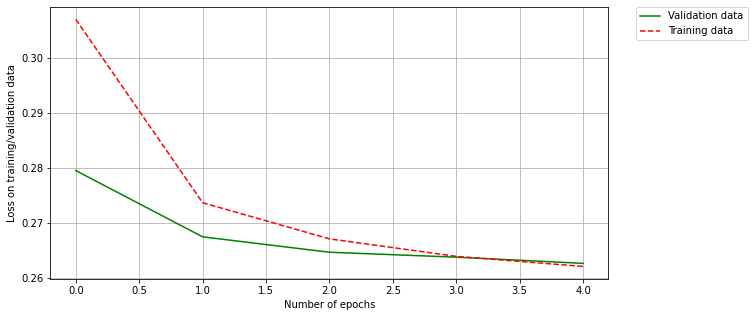

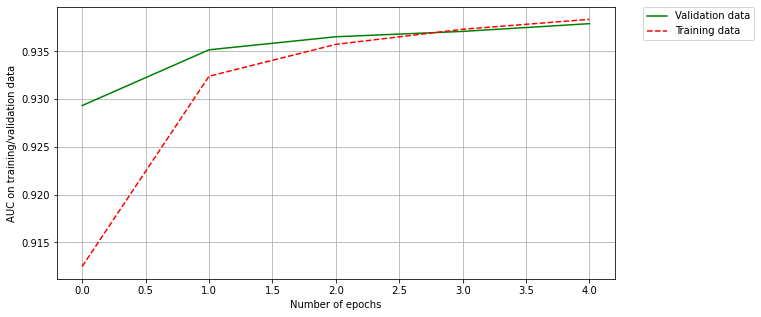

In [24]:
plot_history(history)

In [25]:
y_pred = model.predict([val_padded,  X_val_tm])

In [26]:
# function to find the best threshold 
def optimal_threshold(test, predictions):
  thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  threshold_df = pd.DataFrame({})
  
  for thres in thresholds:
      pred = predictions.copy()
    
      pred[pred >= thres] = 1
      pred[pred < thres] = 0
    
      precision = precision_score(test, pred, average='macro')
      recall = recall_score(test, pred, average='macro')
      f1 = f1_score(test, pred, average='macro')

      df = pd.DataFrame({
          'threshold': round(thres, 4),
          'prediction': round(precision, 4),
          'recall': round(recall, 4),
          'f1': round(f1, 4)
      }, index=[0])

      threshold_df = threshold_df.append(df)
    
  return threshold_df.reset_index(drop=True)

In [27]:
optimal_threshold(y_val, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,prediction,recall,f1
0,0.1,0.4434,0.7259,0.5220
1,0.2,0.5419,0.6457,0.5513
2,0.3,0.5978,0.5923,0.5467
3,0.4,0.7196,0.5403,0.5311
4,0.5,0.6066,0.4101,0.4659
5,0.6,0.6491,0.3664,0.4286
6,0.7,0.6772,0.3138,0.3797
7,0.8,0.7239,0.2182,0.2635
8,0.9,0.4592,0.1419,0.1635


In [31]:
lstm_tm_pred = [[1 if i >=0.2 else 0 for i in pred] for pred in y_pred]

In [32]:
print(metrics.classification_report(y_val,  lstm_tm_pred, digits=6))

              precision    recall  f1-score   support

           0   0.923141  0.999033  0.959589     28950
           1   0.431727  0.898038  0.583122      9837
           2   0.465027  0.613155  0.528916      4348
           3   0.668760  0.668760  0.668760      2388
           4   0.342105  0.027778  0.051383       468
           5   0.420697  0.667667  0.516161      4664

   micro avg   0.670289  0.891245  0.765135     50655
   macro avg   0.541910  0.645739  0.551322     50655
weighted avg   0.724766  0.891245  0.786584     50655
 samples avg   0.696039  0.919905  0.763785     50655



In [33]:
print('Accuracy: ', accuracy_score(y_val, lstm_tm_pred))
print('F1 score: ', f1_score(y_val, lstm_tm_pred, average="macro"))

Accuracy:  0.3486852489030588
F1 score:  0.5513218176703495


In [36]:
model.save("/content/drive/MyDrive/Colab Notebooks/Group Project/lstm_glove_tm")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Group Project/lstm_glove_tm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Group Project/lstm_glove_tm/assets


# Predict on Test Set

In [40]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Group Project/lstm_glove_tm')

In [41]:
final_pred = saved_model.predict([test_padded,  X_test_tm])

In [42]:
optimal_threshold(y_test, final_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,prediction,recall,f1
0,0.1,0.4453,0.7267,0.5200
1,0.2,0.5573,0.6490,0.5531
2,0.3,0.6080,0.5949,0.5478
3,0.4,0.6597,0.5401,0.5301
4,0.5,0.6057,0.4105,0.4659
5,0.6,0.6414,0.3634,0.4238
6,0.7,0.6768,0.3119,0.3770
7,0.8,0.7038,0.2166,0.2607
8,0.9,0.4582,0.1424,0.1636


In [38]:
predictions = [[1 if i >=0.2 else 0 for i in pred] for pred in final_pred]

In [39]:
print(metrics.classification_report(y_test,  predictions, digits=6))

              precision    recall  f1-score   support

           0   0.923172  0.998866  0.959529     43223
           1   0.429823  0.897550  0.581280     14651
           2   0.469750  0.626187  0.536803      6423
           3   0.656114  0.657642  0.656877      3435
           4   0.440000  0.032448  0.060440       678
           5   0.425181  0.681396  0.523626      6993

   micro avg   0.669747  0.893758  0.765705     75403
   macro avg   0.557340  0.649015  0.553092     75403
weighted avg   0.725995  0.893758  0.787727     75403
 samples avg   0.694901  0.920653  0.763424     75403

